# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [78]:
!pip install scikit-learn==1.1.3

  Using cached scikit_learn-1.1.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.0
    Uninstalling scikit-learn-1.2.0:
      Successfully uninstalled scikit-learn-1.2.0


In [79]:
pip install -U scikit-learn

  Using cached scikit_learn-1.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
Note: you may need to restart the kernel to use updated packages.


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression,
    Ridge
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    mean_squared_error, 
    roc_auc_score,
    roc_curve
)
warnings.filterwarnings("ignore")

In [81]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [82]:
data.shape

(10000, 14)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [84]:
def rename(name):
  name = name.replace(name[0], name[0].lower())           
  for i in range(len(name)):
    if name[i].isupper():
      index = name.find(name[i])
      name = name.replace(name[i], name[i].lower())
      name = name[:index] + '_' + name[index:]
  return name

for i in range(len(data.columns)):
  x=data.columns[i]
  x2=rename(x)
  data = data.rename(columns={x:x2})

# функция приведения к змеиному формату наименования столбцов

In [85]:
data.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_crcard',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

In [86]:
data['surname'] = data['surname'].str.lower()
data['geography'] = data['geography'].str.lower()
data['gender'] = data['gender'].str.lower()
# объекты в surname, geography и gender к нижнему регистру

In [87]:
data['age'].sort_values().unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       88, 92])

In [88]:
for i in ['male', 'female']:
    
    data.loc[(data['age'] < 35) & (data['gender'] == i), 'tenure'] = (data.loc
                            [(data['age'] < 35) & (data['gender'] == i), 'tenure'].
                            fillna(data.loc[(data['age'] < 35) & (data['gender'] == i), 'tenure'].median()))
    
    data.loc[(data['age'] >= 35) & (data['age'] <= 65) & (data['gender'] == i), 'tenure'] = (data.loc
                            [(data['age'] >= 35) & (data['age'] <= 65) & (data['gender'] == i), 'tenure'].
                            fillna(data.loc[(data['age'] >= 35) & (data['age'] <= 65) & (data['gender'] == i), 'tenure'].median()))
    
    data.loc[(data['age'] > 65) & (data['gender'] == i), 'tenure'] = (data.loc
                            [(data['age'] > 65) & (data['gender'] == i), 'tenure'].
                            fillna(data.loc[(data['age'] > 65) & (data['gender'] == i), 'tenure'].median()))
    
data.info()    

# заполняем пропуски в tenure (сколько лет человек является клиентом банка) медианным значением учитывая пол(gender) и 
# возростную категорию(age) до 35, от 35 по 65 и более 65 лет.





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_crcard        10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [89]:
data_ohe = data.drop(
    ['row_number', 'customer_id', 'surname'], axis=1
)
# удаляем столбцы row_number, customer_id и surname для провидения кодирования

In [90]:
data_ohe = pd.get_dummies(data_ohe, drop_first=True) 
# подготавливаем датесет data_ohe с преобразованными 
# категориальными признаками в численные с помощью прямого кодирования исключая дамми-ловушку
data_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [91]:
data_ordinal = data.drop(
    ['row_number', 'customer_id', 'surname'], axis=1
)

encoder = OrdinalEncoder()
data_ordinal = pd.DataFrame(encoder.fit_transform(data_ordinal),
                            columns=data_ordinal.columns)

data_ordinal.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_crcard,is_active_member,estimated_salary,exited
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0,1.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0,0.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0,0.0


***Результаты:***

- Проанализировали датасет data с помщью info() и обнаружили пропуски в Tenure.
- Пропуски в Tenure заполнили медианным значением учитывая пол(gender) и возростную категорию(age) до 35, от 35 по 65 и более 65 лет.
- Произвели прямое кодирование исключая дамми-ловушку в результате был сформирован датасет data_ohe

## Исследование задачи

In [92]:
data_train, data_split = train_test_split(
    data_ohe, test_size=0.40, random_state=12345)

data_test, data_valid = train_test_split(
    data_split, test_size=0.50, random_state=12345) # датасет data разбиваем на выборки train/valid/test в пропорции 60/20/20

In [93]:
features_train = data_train.drop('exited', axis=1)
target_train = data_train['exited']

features_test = data_test.drop('exited', axis=1)
target_test = data_test['exited']

features_valid = data_valid.drop('exited', axis=1)
target_valid = data_valid['exited'] # в выборках train/valid/test выделяем признаки и целевой признак

In [94]:
print('train Класс 0 :', target_train.loc[target_train==0].count(), 'train Класс 1 :', target_train.loc[target_train==1].count())
print('valid Класс 0 :', target_valid.loc[target_valid==0].count(), 'valid Класс 1 :', target_valid.loc[target_valid==1].count())
print('test Класс 0 :', target_test.loc[target_test==0].count(), 'test Класс 1 :', target_test.loc[target_test==1].count())

# анализируем дисбаланс классов в выборках

train Класс 0 : 4804 train Класс 1 : 1196
valid Класс 0 : 1577 valid Класс 1 : 423
test Класс 0 : 1582 test Класс 1 : 418


0    0.7963
1    0.2037
Name: exited, dtype: float64


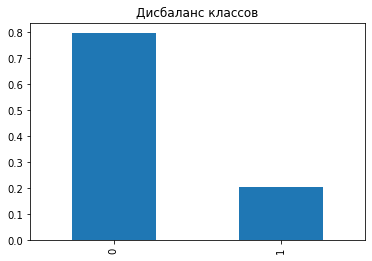

In [95]:
class_frequency = data['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Дисбаланс классов')
plt.show()
# анализируем дисбаланс классов

***Вывод по дисбалансу:***
- Класс 0 в четыре раза превосходит класс 1
- Дисбаланс приведет к тому, что модель будет считать стремиться чаще предсказывать класс 0

In [96]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# производим масштабирование признаков в столбцах 'credit_score', 'age', 'tenure', 'balance', 'estimated_salary'

### Модель DecisionTreeClassifier без учета дисбаланса

In [97]:
best_model_1 = None
result_f1 = 0
for depth in range(1, 20, 1):
    for split in range (10, 150, 10):
        for leaf in range (2, 20, 2):
            model_1 = DecisionTreeClassifier(
                random_state=12345, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf
            ) # обучаем модель
            model_1.fit(features_train, target_train) # обучаем модель
            predict = model_1.predict(features_valid)
            forest_f1 = f1_score(target_valid, predict)
            if forest_f1 > result_f1:
                best_model_1 = model_1 # сохраняем наилучшую модель
                result_f1 = forest_f1 #  сохраняем наилучшее значение метрики F1-мера
        
print(best_model_1)
print('F1-мера:', result_f1)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=90,
                       random_state=12345)
F1-мера: 0.5650969529085872


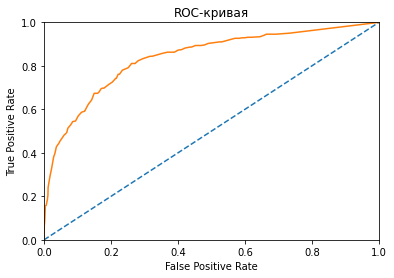

In [98]:
probabilities_valid = best_model_1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # < напишите код здесь >

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--') # строим ROC-кривую случайной модели (выглядит как прямая)

plt.plot(fpr, tpr)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0]) # установливаем границы осей от 0 до 1 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') #   подписываем оси "False Positive Rate" и "True Positive Rate" >

plt.title('ROC-кривая') # < добавляем к графику заголовок "ROC-кривая" функцией plt.title() >
plt.show()

In [99]:
roc_auc_score(target_valid, probabilities_one_valid) # считаем площадь под ROC-кривой

0.8375765098467779

***Вывод***

- Обучили модель DecisionTreeClassifier(max_depth=10, min_samples_leaf=8, min_samples_split=90, random_state=12345)
- Метрика F1-мера показала 0.5650969529085872 для модели, что говорит о дисбалансе в показателях полноты и точности. (требуется доработка модели)
- ROC - кривая показала, что наша модель (оранжевая линия) точнее предсказывает чем случайная модель (синий пунктир)
- Метрика площадь ROC-кривой показала 0.8375765098467779 - показатель ближе к идеальному показателю равному 1 чем к случайной модели равной 0.5
                       

### Модель RandomForestClassifier без учета дисбаланса

In [100]:
best_model_2 = None
result_f1 = 0
for depth in range(1, 6, 1): 
    for est in range(2, 20, 2):
        for split in range(2, 20, 2):
            for leaf in range(1, 20, 1):
                model_2 = RandomForestClassifier(
                random_state=12345, max_depth=depth, n_estimators=est, min_samples_split=split, min_samples_leaf=leaf
            ) # обучите модель с заданным количеством деревьев
                model_2.fit(features_train, target_train) # обучите модель на тренировочной выборке
                predict = model_2.predict(features_valid)
                forest_f1 = f1_score(target_valid, predict)
                if forest_f1 > result_f1:
                    best_model_2 = model_2 # сохраняем наилучшую модель
                    result_f1 = forest_f1 #  сохраняем наилучшее значение метрики F1-мера

print(best_model_2)
print('F1-мера:', result_f1)

RandomForestClassifier(max_depth=4, min_samples_split=6, n_estimators=6,
                       random_state=12345)
F1-мера: 0.49358974358974367


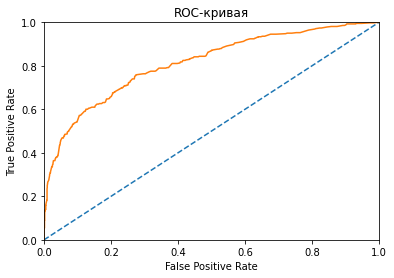

In [101]:
probabilities_valid = best_model_2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # < напишите код здесь >

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--') # строим ROC-кривую случайной модели (выглядит как прямая)

plt.plot(fpr, tpr)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0]) # установливаем границы осей от 0 до 1 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') #   подписываем оси "False Positive Rate" и "True Positive Rate" >

plt.title('ROC-кривая') # < добавляем к графику заголовок "ROC-кривая" функцией plt.title() >
plt.show()

In [102]:
roc_auc_score(target_valid, probabilities_one_valid) # считаем площадь под ROC-кривой

0.8123340693869168

***Вывод***

- Обучили модель RandomForestClassifier(min_samples_leaf=4, n_estimators=6, random_state=12345)
- Метрика F1-мера показала 0.5626822157434401 для модели, что говорит о не приемлемом дисбалансе в показателях полноты и точности. (плохой результат - требуется доработка модели)
- ROC - кривая показала, что наша модель (оранжевая линия) точнее предсказывает чем случайная модель (синий пунктир)
- Метрика площадь ROC-кривой показала 0.8217648496187062 - показатель равноудалеин от идеала равного 1 и случайной модели равной 0.5

### Модель LogisticRegression без учета дисбаланса

In [103]:
best_model_3 = None
result_f1 = 0
Iter = 0
for i in range(100, 10000, 100):
    model_3 = LogisticRegression(random_state=12345, max_iter=i)
    model_3.fit(features_train, target_train) # обучите модель на тренировочной выборке
    predict = model_3.predict(features_valid)
    forest_f1 = f1_score(target_valid, predict)
    if forest_f1 > result_f1:
        best_model_3 = model_3 # сохраняем наилучшую модель
        result_f1 = forest_f1
        Iter = i

print(best_model_3)
print('Iter =', i)
print('F1-мера:', result_f1)

LogisticRegression(random_state=12345)
Iter = 9900
F1-мера: 0.27478260869565213


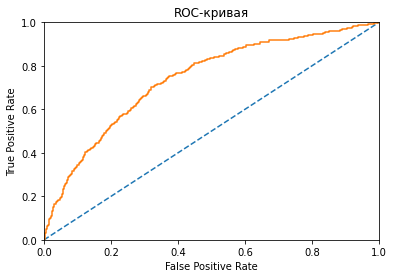

In [104]:
probabilities_valid = model_3.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # < напишите код здесь >

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--') # строим ROC-кривую случайной модели (выглядит как прямая)

plt.plot(fpr, tpr)
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0]) # установливаем границы осей от 0 до 1 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') #   подписываем оси "False Positive Rate" и "True Positive Rate" >

plt.title('ROC-кривая') # < добавляем к графику заголовок "ROC-кривая" функцией plt.title() >
plt.show()

In [105]:
roc_auc_score(target_valid, probabilities_one_valid) # считаем площадь под ROC-кривой

0.7387249633097526

***Вывод***

- Обучили модель LogisticRegression(max_iter=9900, random_state=12345)
- Метрика F1-мера показала 0.27478260869565213 для модели, что говорит о дисбалансе в показателях полноты и точности. (плохой результат - требуется доработка модели)
- ROC - кривая показала, что наша модель (оранжевая линия) точнее предсказывает чем случайная модель (синий пунктир)
- Метрика площадь ROC-кривой показала 0.7387249633097526 - показатель равноудалеин от идеала равного 1 и случайной модели равной 0.5
                     

## Борьба с дисбалансом

### Метод с помощью аргумента class_weight в библиотеке sklearn

In [106]:
best_model_1 = None
result_f1 = 0
for depth in range(1, 10, 1):
    for split in range (10, 150, 10):
        for leaf in range (2, 20, 2):
            model_1 = DecisionTreeClassifier(
                random_state=12345, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf, class_weight='balanced'
            ) # обучаем модель
            model_1.fit(features_train, target_train) # обучаем модель
            predict = model_1.predict(features_valid)
            forest_f1 = f1_score(target_valid, predict)
            if forest_f1 > result_f1:
                best_model_1 = model_1 # сохраняем наилучшую модель
                result_f1 = forest_f1 #  сохраняем наилучшее значение метрики F1-мера
                
print(best_model_1)
print('F1-мера:', result_f1)
probabilities_valid = best_model_1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one_valid))


DecisionTreeClassifier(class_weight='balanced', max_depth=9,
                       min_samples_leaf=18, min_samples_split=120,
                       random_state=12345)
F1-мера: 0.6077872744539411
Площадь ROC-кривой: 0.8432265830773636


In [107]:
best_model_2 = None
result_f1 = 0
for depth in range(1, 6, 1): 
    for est in range(2, 20, 2):
        for split in range(2, 20, 2):
            for leaf in range(1, 20, 1):
                model_2 = RandomForestClassifier(
                    random_state=12345, max_depth=depth, n_estimators=est, min_samples_split=split, 
                    min_samples_leaf=leaf, class_weight='balanced'
                ) # обучите модель с заданным количеством деревьев
                model_2.fit(features_train, target_train) # обучите модель на тренировочной выборке
                predict = model_2.predict(features_valid)
                forest_f1 = f1_score(target_valid, predict)
                if forest_f1 > result_f1:
                    best_model_2 = model_2 # сохраняем наилучшую модель
                    result_f1 = forest_f1 #  сохраняем наилучшее значение метрики F1-мера

print(best_model_2)
print('F1-мера:', result_f1)
probabilities_valid = best_model_2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one_valid))

RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       min_samples_split=14, n_estimators=12,
                       random_state=12345)
F1-мера: 0.6011787819253438
Площадь ROC-кривой: 0.8361074008613776


In [108]:
best_model_3 = None
result_f1 = 0
Iter = 0
for i in range(100, 10000, 100):
    model_3 = LogisticRegression(random_state=12345, max_iter=i, class_weight='balanced')
    model_3.fit(features_train, target_train) # обучите модель на тренировочной выборке
    predict = model_3.predict(features_valid)
    forest_f1 = f1_score(target_valid, predict)
    if forest_f1 > result_f1:
        best_model_3 = model_3 # сохраняем наилучшую модель
        result_f1 = forest_f1
        Iter = i

print(best_model_3)
print('Iter =', i)
print('F1-мера:', result_f1)
probabilities_valid = best_model_3.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one_valid))

LogisticRegression(class_weight='balanced', random_state=12345)
Iter = 9900
F1-мера: 0.4775086505190312
Площадь ROC-кривой: 0.7417726149090575


***Вывод***

- С помощью  class_weight='balanced' удалось получить показатели для:
1. DecisionTreeClassifier F1-мера=0.6077872744539411     Площадь ROC-кривой=0.8432265830773636 
2. RandomForestClassifier F1-мера=0.6011787819253438     Площадь ROC-кривой=0.8361074008613776
3. LogisticRegression     F1-мера=0.4775086505190312    Площадь ROC-кривой=0.7417726149090575
- Лучшая модель получилась DecisionTreeClassifier(class_weight='balanced', max_depth=9,
                       min_samples_leaf=18, min_samples_split=120,
                       random_state=12345)
              

### Метод увеличения выборки - upsampling

In [109]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [110]:
best_model_1 = None
result_f1 = 0
for depth in range(1, 20, 1):
    for split in range (10, 150, 10):
        for leaf in range (2, 20, 2):
            model_1 = DecisionTreeClassifier(
                random_state=12345, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf
            ) # обучаем модель
            model_1.fit(features_upsampled, target_upsampled) # обучаем модель
            predict = model_1.predict(features_valid)
            forest_f1 = f1_score(target_valid, predict)
            if forest_f1 > result_f1:
                best_model_1 = model_1 # сохраняем наилучшую модель
                result_f1 = forest_f1 #  сохраняем наилучшее значение метрики F1-мера
                
print(best_model_1)
print('F1-мера:', result_f1)
probabilities_valid = best_model_1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one_valid))

DecisionTreeClassifier(max_depth=10, min_samples_leaf=18, min_samples_split=140,
                       random_state=12345)
F1-мера: 0.5902578796561605
Площадь ROC-кривой: 0.8226065891037085


In [111]:
best_model_2 = None
result_f1 = 0
for depth in range(1, 6, 1): 
    for est in range(2, 20, 2):
        for split in range(2, 20, 2):
            for leaf in range(1, 20, 1):
                model_2 = RandomForestClassifier(
                random_state=12345, max_depth=depth, n_estimators=est, min_samples_split=split, min_samples_leaf=leaf
            ) # обучите модель с заданным количеством деревьев
                model_2.fit(features_upsampled, target_upsampled) # обучите модель на тренировочной выборке
                predict = model_2.predict(features_valid)
                forest_f1 = f1_score(target_valid, predict)
                if forest_f1 > result_f1:
                    best_model_2 = model_2 # сохраняем наилучшую модель
                    result_f1 = forest_f1 #  сохраняем наилучшее значение метрики F1-мера

print(best_model_2)
print('F1-мера:', result_f1)
probabilities_valid = best_model_2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one_valid))


RandomForestClassifier(max_depth=4, min_samples_leaf=19, n_estimators=12,
                       random_state=12345)
F1-мера: 0.591254752851711
Площадь ROC-кривой: 0.8325448115717817


In [112]:
best_model_3 = None
result_f1 = 0
Iter = 0
for i in range(100, 10000, 100):
    model_3 = LogisticRegression(random_state=12345, max_iter=i)
    model_3.fit(features_upsampled, target_upsampled) # обучите модель на тренировочной выборке
    predict = model_3.predict(features_valid)
    forest_f1 = f1_score(target_valid, predict)
    if forest_f1 > result_f1:
        best_model_3 = model_3 # сохраняем наилучшую модель
        result_f1 = forest_f1
        Iter = i

print(best_model_3)
print('Iter =', i)
print('F1-мера:', result_f1)
probabilities_valid = best_model_3.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one_valid))

LogisticRegression(random_state=12345)
Iter = 9900
F1-мера: 0.47619047619047616
Площадь ROC-кривой: 0.741721645821809


***Вывод***

- С помощью  увеличения выборки удалось получить показатели для:
1. DecisionTreeClassifier F1-мера=0.5902578796561605     Площадь ROC-кривой=0.8226065891037085 
2. RandomForestClassifier F1-мера=0.591254752851711     Площадь ROC-кривой=0.8325448115717817
3. LogisticRegression     F1-мера=0.47619047619047616    Площадь ROC-кривой=0.741721645821809
- Лучшая модель получилась RandomForestClassifier(max_depth=4, min_samples_leaf=19, n_estimators=12,
                       random_state=12345)

### Метод уменьшения выборки - downsampling

In [113]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

In [114]:
best_model_1 = None
result_f1 = 0
for depth in range(1, 20, 1):
    for split in range (10, 150, 10):
        for leaf in range (2, 20, 2):
            model_1 = DecisionTreeClassifier(
                random_state=12345, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf
            ) # обучаем модель
            model_1.fit(features_downsampled, target_downsampled) # обучаем модель
            predict = model_1.predict(features_valid)
            forest_f1 = f1_score(target_valid, predict)
            if forest_f1 > result_f1:
                best_model_1 = model_1 # сохраняем наилучшую модель
                result_f1 = forest_f1 #  сохраняем наилучшее значение метрики F1-мера
                
print(best_model_1)
print('F1-мера:', result_f1)
probabilities_valid = best_model_1.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one_valid))
thebest_model_1 = best_model_1

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=20,
                       random_state=12345)
F1-мера: 0.6131386861313869
Площадь ROC-кривой: 0.8452615988403033


In [115]:
best_model_2 = None
result_f1 = 0
for depth in range(1, 6, 1): 
    for est in range(2, 20, 2):
        for split in range(2, 20, 2):
            for leaf in range(1, 20, 1):
                model_2 = RandomForestClassifier(
                random_state=12345, max_depth=depth, n_estimators=est, min_samples_split=split, min_samples_leaf=leaf
            ) # обучите модель с заданным количеством деревьев
                model_2.fit(features_downsampled, target_downsampled) # обучите модель на тренировочной выборке
                predict = model_2.predict(features_valid)
                forest_f1 = f1_score(target_valid, predict)
                if forest_f1 > result_f1:
                    best_model_2 = model_2 # сохраняем наилучшую модель
                    result_f1 = forest_f1 #  сохраняем наилучшее значение метрики F1-мера

print(best_model_2)
print('F1-мера:', result_f1)
probabilities_valid = best_model_2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one_valid))

RandomForestClassifier(max_depth=5, min_samples_leaf=6, min_samples_split=16,
                       n_estimators=10, random_state=12345)
F1-мера: 0.5922509225092252
Площадь ROC-кривой: 0.8364019722038585


In [116]:
best_model_3 = None
result_f1 = 0
Iter = 0
for i in range(100, 10000, 100):
    model_3 = LogisticRegression(random_state=12345, max_iter=i)
    model_3.fit(features_downsampled, target_downsampled) # обучите модель на тренировочной выборке
    predict = model_3.predict(features_valid)
    forest_f1 = f1_score(target_valid, predict)
    if forest_f1 > result_f1:
        best_model_3 = model_3 # сохраняем наилучшую модель
        result_f1 = forest_f1
        Iter = i

print(best_model_3)
print('Iter =', i)
print('F1-мера:', result_f1)
probabilities_valid = best_model_3.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_valid, probabilities_one_valid))

LogisticRegression(random_state=12345)
Iter = 9900
F1-мера: 0.48547008547008547
Площадь ROC-кривой: 0.7412554285825647


***Вывод***

- С помощью  уменьшения выборки удалось получить показатели для:
1. DecisionTreeClassifier F1-мера=0.6131386861313869     Площадь ROC-кривой=0.8452615988403033
2. RandomForestClassifier F1-мера=0.5922509225092252     Площадь ROC-кривой=0.8364019722038585
3. LogisticRegression     F1-мера=0.48547008547008547    Площадь ROC-кривой=0.7412554285825647
- Лучшая модель получилась DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=20,
                       random_state=12345)

***Общий вывод:***

- Лучшая модель RandomForestClassifier с метриками F1-мера=0.6203904555314533     Площадь ROC-кривой=0.8479517172834676 (с применением увеличения выборки)

## Тестирование модели

In [117]:
predicted_test = thebest_model_1.predict(features_test)
print('F1-мера:', f1_score(target_test, predicted_test))

accuracy_test = accuracy_score(target_test, predicted_test)
print('Accuracy:', accuracy_test)

probabilities_test = thebest_model_1.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(target_test, probabilities_one_test))
thebest_model_1

F1-мера: 0.599388379204893
Accuracy: 0.8035
Площадь ROC-кривой: 0.8351535516183863


DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=20,
                       random_state=12345)

***Выводы***

1. Лучшая модель DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=20,
                       random_state=12345) на тестовой выборке показала:
                       
- F1-мера - 0.599388379204893
- Площадь ROC-кривой: 0.8351535516183863

Условие проекта по доведения метрики F1-меры более 0.59 - выполнено
  
